# A. Choose 5-10 gold examples per Intent

In [1]:
import os
from pathlib import Path

from framework.utils import eda_utils 

In [2]:
CARBON_BOT = Path('../../../../carbon-bot-e2e')

## Which intents? What examples do we have?
---

In [4]:
nlu_examples = eda_utils.load_nlu_data(CARBON_BOT /"data" / "nlu.yml")

/Users/kabu/Documents/workspace/rasa2/rasa/shared/utils/io.py:98: UserWarning: Training data file /Users/kabu/Documents/workspace/carbon-bot-e2e/data/nlu.yml has a lower format version than your Rasa Open Source installation: 2.0 < 3.1. Rasa Open Source will read the file as a version 3.1 file. Please update your version key to 3.1. See https://rasa.com/docs/rasa/training-data-format.


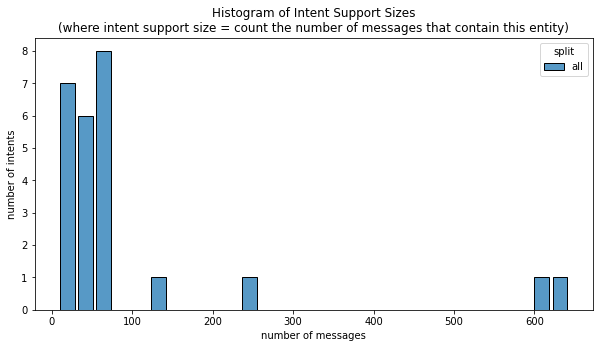

In [5]:
intent_support = eda_utils.intent_support({'all' : nlu_examples})

In [6]:
intent_support

,intent,all
0,faq,643
1,inform,616
2,affirm,255
3,inquire-ask_clarification-offsets,124
4,estimate_emissions,73
5,deny,69
6,insult,63
7,greet,63
8,why,59
9,inform_notunderstanding,58


## Try to filter out some not so nice examples automatically
---

In [7]:
%%capture
!pip install pyspellchecker

In [8]:
from spellchecker import SpellChecker
import regex

In [9]:
col_not_nice = 'maybe-not-nice'
sc = SpellChecker()
nlu_examples[col_not_nice] = nlu_examples['text'].apply(lambda text : sc.unknown(words = regex.sub(
            # there is a space or an end of a string after it
            r"[^\w#@&]+(?=\s|$)|"
            # there is a space or beginning of a string before it
            # not followed by a number
            r"(\s|^)[^\w#@&]+(?=[^0-9\s])|"
            # not in between numbers and not . or @ or & or - or #
            # e.g. 10'000.00 or blabla@gmail.com
            # and not url characters
            r"(?<=[^0-9\s])[^\w._~:/?#\[\]()@!$&*+,;=-]+(?=[^0-9\s])",
            " ",
            text,
        ).split()))

In [10]:
nlu_examples[nlu_examples[col_not_nice].astype(bool)]

,text,intent,entities,maybe-not-nice
5,I'd just forward them the link,affirm,[],{d}
6,I'd like to do that,affirm,[],{d}
7,I'll be flying cheap,affirm,[],{ll}
12,"Ok, let's do that.",affirm,[],{s}
23,_YES_!,affirm,[],{_yes_}
...,...,...,...,...
2490,A t e you board today,faq,[],{t}
2492,Habevyou been in s fight,faq,[],"{s, habevyou}"
2508,What's your age,faq,[],{s}
2510,gime me some details about you,faq,[],{gime}


In [11]:
nlu_examples

,text,intent,entities,maybe-not-nice
0,**YES**,affirm,[],{}
1,*YES*,affirm,[],{}
2,"As I've said, yes.",affirm,[],{}
3,I think so,affirm,[],{}
4,I think yes,affirm,[],{}
...,...,...,...,...
2512,whats'your name,faq,[],{}
2513,what's your age?,faq,[],{s}
2514,who are you,faq,[],{}
2515,Carbon offsets will not affect climate !,faq,[],{}


In [12]:
nlu_examples_checked = nlu_examples[~nlu_examples[col_not_nice].astype(bool)]

In [13]:
f"{len(nlu_examples_checked)} out of {len(nlu_examples)} examples are left after the spell check"

'1902 out of 2517 examples are left after the spell check'

In [14]:
nlu_examples_grouped = { intent : group for intent, group in nlu_examples.groupby('intent')}
nlu_examples_checked_and_grouped = {intent : group for intent, group in nlu_examples_checked.groupby('intent')}
intents = sorted(nlu_examples_grouped.keys())

## Iterate Through Samples and Build a "Nice" Data Set
---

In [15]:
idx = 1 # 0,1,2, .....

print(f"Out of {len(nlu_examples_grouped)} only the following {len(nlu_examples_checked_and_grouped[intents[idx]])} passed the spell check:") 
display(
    nlu_examples_checked_and_grouped[intents[idx]]
    .reset_index()
    .sample(10)
)

Out of 25 only the following 212 passed the spell check:


,index,text,intent,entities,maybe-not-nice
143,181,always,affirm,[],{}
88,116,yes i am very much interested,affirm,[],{}
130,166,please provide more accurate estimates,affirm,[],{}
104,134,suer,affirm,[],{}
81,107,ya sure,affirm,[],{}
50,70,umm ok,affirm,[],{}
6,9,Of course,affirm,[],{}
15,19,Yeah,affirm,[],{}
120,154,"Yes, I am interested",affirm,[],{}
156,194,"yes, sounds good",affirm,[],{}


## Inspect the Result
---

In [16]:
!head gold-samples.yml

version:  2.0 
nlu:
- intent: why
  examples: |
     - why should I pay?
     - how is that important
     - for what reason?
     - why
     - what for?
     - why are you asking that?


In [18]:
gold_samples = eda_utils.load_nlu_data("gold-samples.yml")

/Users/kabu/Documents/workspace/rasa2/rasa/shared/utils/io.py:98: UserWarning: Training data file /Users/kabu/Documents/workspace/empirical-analysis/workspace/other/carbon-bot_nice-vs-other/gold-samples.yml has a lower format version than your Rasa Open Source installation: 2.0 < 3.1. Rasa Open Source will read the file as a version 3.1 file. Please update your version key to 3.1. See https://rasa.com/docs/rasa/training-data-format.


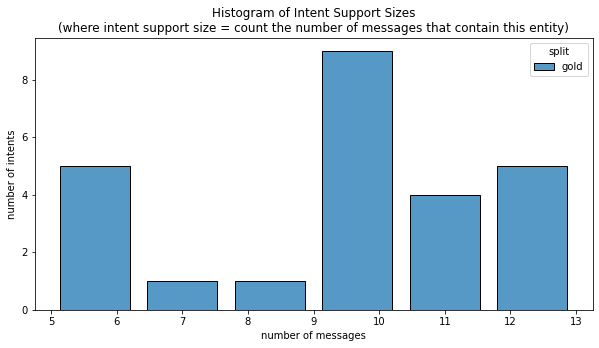

In [21]:
gold_intent_support = eda_utils.intent_support({'gold' : gold_samples})

In [22]:
gold_intent_support

,intent,gold
0,inform,13
1,thank,12
2,express_positive-emo,12
3,express_uncertainty,12
4,vulgar,12
5,why,11
6,express_surprise,11
7,greet,11
8,inquire-ask_clarification-offsets,11
9,inform_notunderstanding,10
